<h1><center>
Assignment 2 - Reinforcement Learning
</center></h1>

<h3>Contributors</h3>
<dev>
<li>Eric Egli, 15-705-411</li>
<li>Kirat Virmani, 22-738-538</li>
<li>Diana Alexandra Dragos, 21-742-648</li>
<li>Abdlrahman Essa, 20-752-663</li>
<li>Hasan Atak, 20-751-897</li>
</dev>

# Preparation

In [7]:
# The following code was adapted from a demo given by Andreas Krause in the course Probabilistic AI at ETH in 2021.

import numpy as np

import torch
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import copy 

from rllib.environment.mdps import EasyGridWorld
from rllib.value_function import TabularValueFunction
from rllib.policy import TabularPolicy

environment = EasyGridWorld()
gamma = 0.9

# Plotters
def policy2str(policy):
    left = u'\u2190'
    right = u'\u2192'
    up = u'\u2191'
    down = u'\u2193'
    policy_str = ""
    if 0 == policy:
        policy_str += down 
    if 1 == policy:
        policy_str += up 
    if 2 == policy:
        policy_str += right
    if 3 == policy:
        policy_str += left
    return policy_str

def plot_value_function(value_function, ax):
    ax.imshow(value_function, vmin=-1, vmax=30)
    rows, cols = value_function.shape
    for row in range(rows):
        for col in range(cols):
            ax.text(row, col, f"{value_function[col, row]:.1f}", ha="center", va="center", color="w", fontsize=24)

def plot_policy(policy, ax):
    rows, cols = policy.shape
    ax.imshow(np.zeros((rows, cols)))
    for row in range(environment.height):
        for col in range(environment.width):
            ax.text(col, row, policy2str(policy[row, col]), ha="center", va="center", color="r", fontsize=24)

def plot_value_and_policy(value_function, policy):
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

    plot_value_function(value_function, axes[0])
    plot_policy(policy, axes[1])

## Task 1 - Policy Evaluation

In [8]:
# print all the methods in environment
print([method for method in dir(environment) if callable(getattr(environment, method))])

['__class__', '__class_getitem__', '__delattr__', '__dir__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '_action_to_grid', '_build_mdp', '_grid_to_state', '_is_valid', '_state_to_grid', 'check_transitions', 'close', 'get_state', 'initial_state', 'render', 'reset', 'seed', 'set_state', 'step']


In [9]:
# print all the attributes in enviornment
print([attr for attr in dir(environment) if not callable(getattr(environment, attr))])

['__abstractmethods__', '__annotations__', '__dict__', '__doc__', '__module__', '__orig_bases__', '__parameters__', '__slots__', '__weakref__', '_abc_impl', '_np_random', '_state', '_time', 'action_scale', 'action_space', 'dim_action', 'dim_observation', 'dim_reward', 'dim_state', 'discrete_action', 'discrete_observation', 'discrete_state', 'goal', 'height', 'metadata', 'name', 'np_random', 'num_actions', 'num_observations', 'num_states', 'observation_space', 'render_mode', 'reward_range', 'spec', 'state', 'terminal_states', 'time', 'transitions', 'unwrapped', 'width']


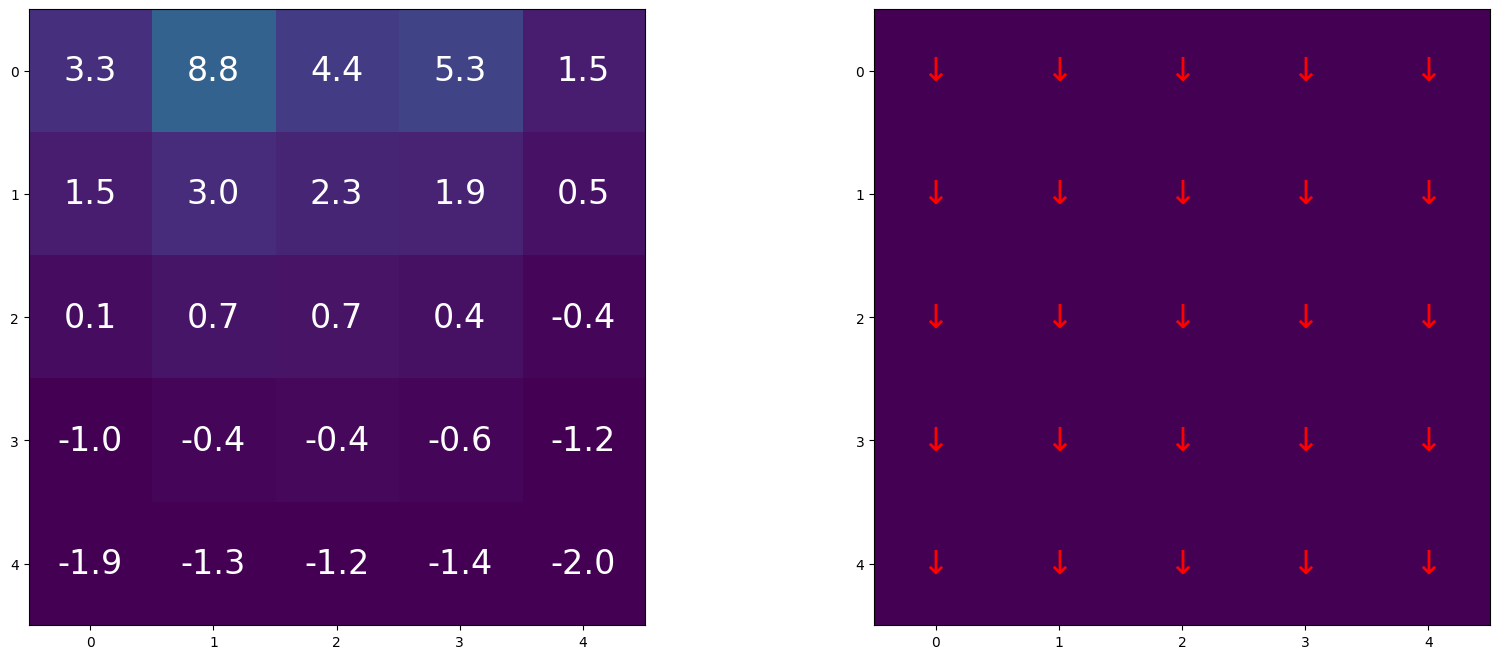

In [10]:
def init_policy_and_value_function():
    ### ---Task 1.1--- ###
    ### YOUR CODE HERE ###
    # num_states and num_actions is given by the environment
    value_function = TabularValueFunction(num_states=environment.num_states)
    policy = TabularPolicy(num_states=environment.num_states, num_actions=environment.num_actions)

    # there are no future rewards in the terminal states
    for state in environment.terminal_states:
        value_function.set_value(state, 0)
    ### YOUR CODE END  ###
    
    return policy, value_function

def linear_system_policy_evaluation(environment, policy, gamma, value_function):

    P, r = build_mrp_matrices(environment=environment, policy=policy)

    ### ---Task 1.2--- ###
    ### YOUR CODE HERE ###

    # inspired by the rllib implemention of the linear system policy evaluation
    inverse_v = (torch.eye(environment.num_states) - gamma * P).inverse()
    # matrix multiplication of inverse with reward vector
    vals = inverse_v @ r
    ### YOUR CODE END  ###    
    
    for state in range(environment.num_states):
        value_function.set_value(state, vals[state].item())

    return value_function

def build_mrp_matrices(environment, policy):
    mrp_kernel = np.zeros((environment.num_states, environment.num_states))
    mrp_reward = np.zeros((environment.num_states))

    for state in range(environment.num_states):
        state = torch.tensor(state).long()
        policy_ = Categorical(logits=policy(state))

        for a, p_action in enumerate(policy_.probs):
            for transition in environment.transitions[(state.item(), a)]:
                with torch.no_grad():
                    p_ns = transition["probability"]
                    mrp_reward[state] += p_action * p_ns * transition["reward"]
                    mrp_kernel[state, transition["next_state"]
                               ] += p_action * p_ns

    return mrp_kernel, mrp_reward

### ---Task 1.3--- ###
policy, value_function = init_policy_and_value_function()
value_function = linear_system_policy_evaluation(environment, policy, gamma, value_function)

plot_value_and_policy(value_function.table.reshape(5, 5).detach().numpy(),
                      policy.table.argmax(0).reshape(5, 5).detach().numpy())

# Task 2 - Policy Iteration

## Theory Question 1

### Question (a)

The Bellman operator, as introduced here, chooses the greedy action $a$, i.e., the action with maximum value for some state $x$. Our goal is to show that there is always one (or multiple) best action $a$ (i.e, the action with the highest action-value) for any state $x$ under some policy $\pi$.

\begin{align*}
BV^{\pi}(x) \geq V^{\pi}(x) \forall x \in X
\end{align*}

_Note that the time step $t$ is omitted in this first task for simplicity (it does not change the argument). Also, notation has been adjusted to follow the course._

We can substitute the Bellman operator into the equation (1) and express  $V^{\pi}(s)$ via the Bellman equation (2) as introduced in Sutton & Barto (2018):

\begin{align}
BV^{\pi}(s) &=\underset{a}{\max} \sum_{s^\prime, r}p(s^\prime,r\;|\;s,a)\left[r + \gamma V^\pi(s^\prime) \right]\\
 &\geq \sum_a\pi(a\;|\;s)\;\sum_{s^\prime, r}p(s^\prime, r\;|\;s,a)[r+\gamma V^\pi(s^\prime)]\\
 &= V^{\pi}(s)
\end{align}


Let's look at the two possible cases for the inequality to hold:
1. $BV^{\pi}(s)=V^{\pi}(s)$ - **all** actions in $s$ are optimal
2. $BV^{\pi}(s)\geq V^{\pi}(s)$ - **not all** actions in $s$ are optimal

The inqeuality holds.


### Question (b)

\begin{align}
V^{\pi_{t+1}}(x) \geq BV^{\pi_t}(x) \forall x \in X
\end{align}

Fixed point iteration (inspired by the the policy iteration algorithm from the book and the policy improvement theorem) to calculate $V^{\pi_{t+1}}$ based on $V^{\pi_t}$ using the greedy policy $\pi_{t+1}$:
\begin{align}
\triangle_0 \leftarrow V^{\pi_t}\\
\text{repeat for } &i=1 \text{ to } T: \\
&\triangle_{i} \leftarrow r(s, \pi_{t+1}(s))+\mathbb{E}_{s'|s, \pi_{t+1}}(s)\triangle_{i-1}\\
\text{end}
\end{align}

We start off with $\triangle_0=V^{\pi_t}$ and then get $\triangle_1=BV^{\pi_t}$ in the first iteration (since $B$ constructs a greedy policy, we can use it as an update rule). We use the proof from the previous task, $BV^{\pi_t}(s) \geq V^{\pi_t}(s) \forall s \in S$ to show that $\triangle_i$ is monotonically increasing, i.e., $\triangle_i \geq \triangle_{i-1}$:

\begin{align}
\triangle_i(s) &= r(s, \pi_{t+1}(s))+\mathbb{E}_{s'|s, \pi_{t+1}}(s)\triangle_{i-1}\\
&\geq r(s, \pi_{t+1}(s))+\mathbb{E}_{s'|s, \pi_{t+1}}(s)\triangle_{i-2}\\
&= \triangle_{i-1}(s)
\end{align}

The inequality holds.

### Question (c)

Given:

\begin{align}
V^* &\geq V^{\pi} \;\forall\; \pi &\textit{(task description)} \\
V^* &= BV^* &\textit{(task description)}   \\
V^{\pi_{t+1}}(s) &\geq BV^{\pi_t}(s) &\textit{(previous exercise)}\\
\end{align}

Since (1) holds, we can subtract (2) from both sides of the inequality in (3). Because we're dealing with functions, we use the uniform norm $||f||_\infty = \sup{|f(s)|: s\ \in S}$ to express the inequality:

\begin{align}
||V^{\pi_{t+1}}(s) - V^*||_\infty &\leq ||BV^{\pi_t}(s) - BV^*||_\infty\\
&\leq ||B(V^{\pi_t}(s) - V^*)||_\infty\\
&\leq \gamma||V^{\pi_t}(s) - V^*||_\infty\\
&\leq \gamma^t||V^{\pi_1}(s) - V^*||_\infty
\end{align}

Hence, with every iteration (i.e., time step $t$), the absolute difference between the optimal value function $V^*$ and the value function $V^{\pi_{t+1}}$ gets smaller. In the limit ($t \rightarrow \infty$), the difference is 0 and linear convergence is therefore guaranteed as long as $\gamma < 1$, which is given.

## Task 2 - Policy Iteration

Iterations until convergence: 5


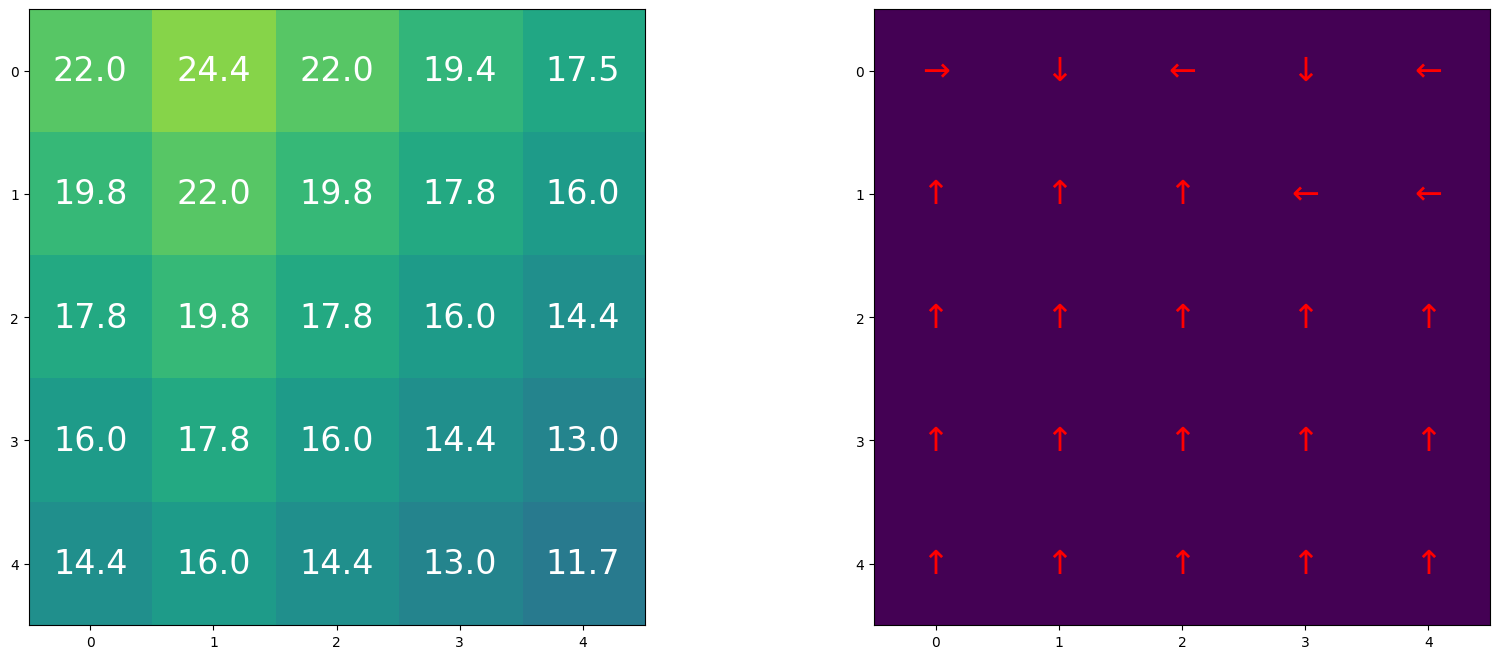

In [11]:
# Policy Iteration
def policy_iteration(environment, gamma):
    """Implement Policy Iteration algorithm.

    Parameters
    ----------
    gamma: float.
        discount factor.

    References
    ----------
    Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction.
    MIT press.
    Chapter 4.3

    """
    
    policy, value_function = init_policy_and_value_function()
    
    iters = 0
    while True:
        iters = iters + 1
        # Evaluate the policy.
        value_function = linear_system_policy_evaluation(environment, policy, gamma, value_function)

        policy_stable = True
        # iterate through all states
        for state in range(environment.num_states):
            # initialize values
            value_ = torch.zeros(environment.num_actions)
            
            # iterate through possible actions
            for action in range(environment.num_actions):
                value_estimate = 0
                
                # iterate through transitions
                for transition in environment.transitions[(state, action)]:
                    next_state = torch.tensor(transition["next_state"]).long()
                    reward = torch.tensor(transition["reward"]).double()
                    transition_probability = transition["probability"]

                    
                    ### ---Task 2.1--- ###
                    ### YOUR CODE HERE ###

                    estimate_calc =  reward + gamma * value_function(next_state)
                    value_estimate = value_estimate + transition_probability * estimate_calc
                    
                    ### YOUR CODE END

                value_[action] = value_estimate

            state = torch.tensor(state).long()
            old_policy = policy(state)
            old_action = torch.argmax(old_policy)

            action = torch.argmax(value_)
            policy.set_value(state, action)
            
            ### ---Task 2.2--- ###
            ### YOUR CODE HERE ###
            
            if (action == old_action).all() and policy_stable:
                policy_stable = True
            else:
                policy_stable = False
            
            ### YOUR CODE END  ###

        if policy_stable:
            break

    return value_function, policy, iters
    
### ---Task 2.3--- ###
value_function, policy,iters = policy_iteration(environment, gamma)
plot_value_and_policy(value_function.table.reshape(5, 5).detach().numpy(),
                      policy.table.argmax(0).reshape(5, 5).detach().numpy())
print(f"Iterations until convergence: {iters}")

## Task 3 - Value Iteration

Iterations until convergence: 30


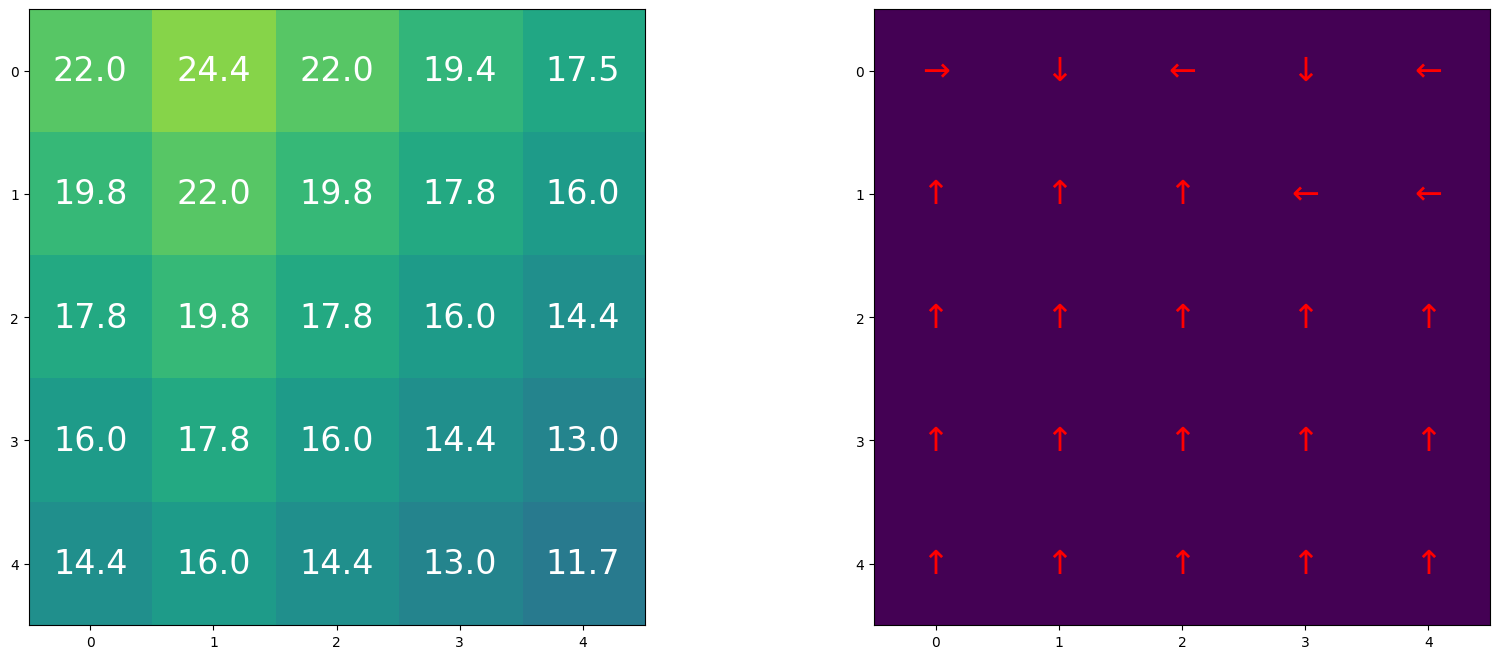

In [29]:
def value_iteration(environment, gamma, eps=1e-6, max_iter=1000):
    """Implement of Value Iteration algorithm.

    Parameters
    ----------
    gamma: float
        discount factor.
    eps: float 
        desired precision.
    max_iter: int 
        Max number of iterations. 
    value_function: TabularValueFunction, optional. 
        Initial value function. 
        
    Returns
    -------
    value_function: TabularValueFunction
        Optimal value function.
    policy: Tabular Policy 
        Optimal policy. 
    num_iter: int
        Number of iterations to reach `eps' accuracy. 

    References
    ----------
    Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction.
    MIT press.
    Chapter 4.4

    """
    # Initialize policy and value function
    policy, value_function = init_policy_and_value_function()
    
    # Iterate until convergence or maximum number of iterations is reached
    for num_iter in range(max_iter):
        error = torch.tensor(0.0)
        
        # Copy old value function for error calculation
        old_value_function = copy.deepcopy(value_function)
        
        for state in range(environment.num_states):
            ### ---TASK 3.1--- ###
            ### YOUR CODE HERE ###            
            # Initialize variables for tracking maximum value and corresponding action
            val_max = torch.zeros(1)
            act_max = torch.zeros(1)
            ### YOUR CODE END ###

            for action in range(environment.num_actions):
                value_estimate = 0

                # In practice, we do not have access to environment.transitions, but only to samples of it!.
                for transition in environment.transitions[(state, action)]:
                    next_state = torch.tensor(transition["next_state"]).long()
                    reward = torch.tensor(transition["reward"]).double()
                    transition_probability = transition["probability"]

                    ### ---TASK 3.2--- ###
                    ### YOUR CODE HERE ###
                    # Calculate the value estimate for each transition and update the overall value estimate of the action
                    estimate_calc = reward + gamma * value_function(next_state)
                    value_estimate += transition_probability * estimate_calc
                    ### YOUR CODE END ###

                # Update the maximum value and corresponding action
                if value_estimate > val_max : 
                    val_max = value_estimate
                    act_max = torch.tensor(action)
                    
            # Update the value function for the state
            state = torch.tensor(state).long()

            ### ---TASK 3.3--- ###
            ### YOUR CODE HERE ###
            # For each state, calculate the error between the last iteration and the current iteration, 
            # and set the value function of the state to the new valueestimate.
            error = torch.maximum(error, torch.abs(old_value_function(state) - val_max))
            value_function.set_value(state, val_max)
            ### YOUR CODE END ### 

            policy.set_value(state, act_max)

        # Check for convergence
        if error < eps:
            break

    return value_function, policy, num_iter



### ---Task 3.4--- ###
value_function, policy, num_iter = value_iteration(environment, gamma)
plot_value_and_policy(value_function.table.reshape(5, 5).detach().numpy(),
                      policy.table.argmax(0).reshape(5, 5).detach().numpy())
print(f"Iterations until convergence: {num_iter}")

## Theory Question 2

In your own words, compare and contrast policy iteration and value iteration in a few sentences. I.e. what are the advantages and disadvantages of either? What are the types of problem to which they can be applied? Which is faster under which circumstances?

Policy iteration works by iteratively improving a policy until an optimal policy is found, while value iteration works by iteratively computing the optimal value function.

Policy iteration is faster for small problems, but requires more computation for larger problems. It also requires a model of the problem, including transition probabilities and reward function.

Value iteration can be more efficient for larger problems, but may take longer to converge.

Both algorithms can be applied to problems with a finite number of states and actions, but the choice between them depends on the specifics of the problem at hand.